This is the script identification task implementation on CVSI-2015 dataset. The first method in our report only uses the mobilenet model by resizing each image into (64, 96, 1). By modifying the constructed transformer encoder class, we can choose to add positional encoding or not (which is the second method in our report), or directly perform average pooling after mobilenet output (which is the third method in our report). The image data can be downloaded from http://www.ict.griffith.edu.au/cvsi2015/Dataset.php after registration on the website. The image data and labels are transformed into lists of numpy arrays and lists of integers respectively and stored as pickles in our preprocessing.

In [ ]:
# check gpu status
!nvidia-smi

Mon Nov 29 06:05:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    36W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# mount Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, DepthwiseConv2D
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import ReLU, LeakyReLU, Flatten, Dense
from PIL import Image
import glob
import os
import pickle

Create ground truth label mapping, import image data and perform sample visualization

In [ ]:
# create dictionary mapping between script type and corresponding id label
id_to_script = {0: 'Arabic', 1: 'Bengali', 2: 'English', 3: 'Gujrathi', 4: 'Hindi', 
                5: 'Kannada', 6: 'Oriya', 7: 'Punjabi', 8: 'Tamil', 9: 'Telegu'}
script_to_id = {v: k for (k, v) in id_to_script.items()}

In [ ]:
script_to_id

{'Arabic': 0,
 'Bengali': 1,
 'English': 2,
 'Gujrathi': 3,
 'Hindi': 4,
 'Kannada': 5,
 'Oriya': 6,
 'Punjabi': 7,
 'Tamil': 8,
 'Telegu': 9}

In [ ]:
# unpickle training data
with open("./gdrive/MyDrive/Colab_Notebooks/task_cvsi/train_data", "rb") as fp:   # Unpickling
  train_data = pickle.load(fp)

In [ ]:
# unpickle training label
with open("./gdrive/MyDrive/Colab_Notebooks/task_cvsi/train_label", "rb") as fp:   # Unpickling
  label = pickle.load(fp)

In [ ]:
len(train_data) # 6412

6412

In [ ]:
# unpickle validation data
with open("./gdrive/MyDrive/Colab_Notebooks/task_cvsi/val_data", "rb") as fp:   # Unpickling
  val_data = pickle.load(fp)

In [ ]:
# unpickle validation label
with open("./gdrive/MyDrive/Colab_Notebooks/task_cvsi/val_label", "rb") as fp:   # Unpickling
  val_label = pickle.load(fp)

In [ ]:
len(val_data) # 1069

1069

In [ ]:
# unpickle test data
with open("./gdrive/MyDrive/Colab_Notebooks/task_cvsi/test_data", "rb") as fp:   # Unpickling
  test_data = pickle.load(fp)

In [ ]:
# unpickle test label
with open("./gdrive/MyDrive/Colab_Notebooks/task_cvsi/test_label", "rb") as fp:   # Unpickling
  test_label = pickle.load(fp)

In [ ]:
len(test_data) # 3207

3207

Arabic
(38, 104, 3)


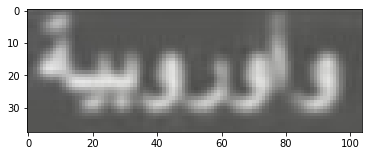

In [ ]:
# visualiza an image sample
idx = 10
print(id_to_script[label[idx]])
xx = np.asarray(train_data[idx])
print(xx.shape)
xx = xx.astype(int)
plt.imshow(xx)

(1, 64, 192, 1)


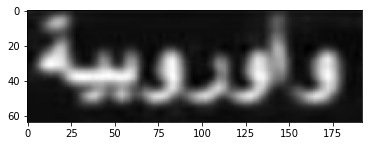

In [ ]:
# grayscaling and resizing image to multiples of 64
img = tf.image.rgb_to_grayscale(xx)
h, w = img.shape[0],img.shape[1]
new_w = int(((w*64/h - 1)//64 + 1) * 64)  # can use np.ceil() instead for simplicity
xxx = tf.image.resize(tf.reshape(img, [1,h,w,1]), (64, new_w),
                      method = tf.image.ResizeMethod.BILINEAR)
print(xxx.shape)
plt.imshow(xxx[0,:,:,0], cmap='gray')

In [ ]:
# convert into patches of (64, 64, 1)
img_patches = tf.convert_to_tensor([xxx[0,:,i*64:(i+1)*64,:] for i in range(new_w//64)])
img_patches.shape

TensorShape([3, 64, 64, 1])

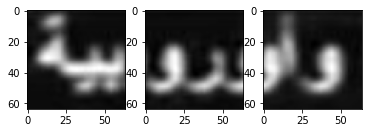

In [ ]:
# visualize patches
plt.subplot(1, 3, 1)
plt.imshow(img_patches[0][...,0], cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(img_patches[1][...,0], cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(img_patches[2][...,0], cmap='gray')

In [ ]:
# examine image sizes and aspect ratios
shapes = np.asarray([[data.shape[0], data.shape[1]] for data in train_data])
print(np.min(shapes, axis=0))
print(np.max(shapes, axis=0))
# only min/max values of height and width, not necessarily corresponding to existing shapes
# aspect ratio (width over height)
print(np.min(shapes[:,1]/shapes[:,0]))
print(np.max(shapes[:,1]/shapes[:,0]))
# max aspect ratio observed in train data, which is 10.74 (hence making max length as 11)

[ 9 18]
[149 461]
0.6206896551724138
10.741935483870968


In [ ]:
# create the function, which takes in grayscle images and resizes and converts them into
# collections of (64, 64, 1) tensors, as displayed in the examples above
def to_patches(gray_img):
  gray_img /= 255
  h, w = gray_img.shape[0], gray_img.shape[1]
  new_w = int(((w*64/h - 1)//64 + 1) * 64)
  img = tf.image.resize(tf.reshape(gray_img, [1,h,w,1]), (64, new_w),
                        method = tf.image.ResizeMethod.BILINEAR)
  patches = tf.convert_to_tensor([img[0, :, i*64:(i+1)*64, :] for i in range(new_w//64)])
  return patches

Model Construction

In [ ]:
# Build customized mobileNet model
# MobileNet block
def mobilnet_block (x, filters, strides):
  x = DepthwiseConv2D(kernel_size = 3, strides = strides, padding = 'same')(x)
  x = BatchNormalization(epsilon=1e-6)(x)
  x = LeakyReLU(alpha=0.1)(x)
    
  x = Conv2D(filters = filters, kernel_size = 1, strides = 1)(x)
  x = BatchNormalization(epsilon=1e-6)(x)
  x = LeakyReLU(alpha=0.1)(x)
    
  return x

In [ ]:
#stem of the model
input = Input(shape = (64, 64, 1))
x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(input)
x = BatchNormalization(epsilon=1e-6)(x)
x = LeakyReLU(alpha=0.1)(x)
# main part of the model
x = mobilnet_block(x, filters = 64, strides = 1)
x = mobilnet_block(x, filters = 128, strides = 2)
x = mobilnet_block(x, filters = 128, strides = 1)
x = mobilnet_block(x, filters = 256, strides = 2)
x = mobilnet_block(x, filters = 256, strides = 1)
x = mobilnet_block(x, filters = 512, strides = 2)
x = mobilnet_block(x, filters = 512, strides = 1)

# # full mobilenet has five blocks below, we only use two blocks here
# for _ in range (5):
#   x = mobilnet_block(x, filters = 512, strides = 1)
x = mobilnet_block(x, filters = 512, strides = 1)
x = mobilnet_block(x, filters = 512, strides = 1)

x = mobilnet_block(x, filters = 1024, strides = 2)
x = mobilnet_block(x, filters = 1024, strides = 1)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = keras.layers.Flatten()(x)
mobile_out = keras.layers.Dense(512)(x)

print(mobile_out.shape)

(None, 512)


In [ ]:
# build model and summary
mobile_net = keras.Model(inputs=input, outputs=mobile_out)
mobile_net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 32, 32, 32)       320       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128   

Create transformer encoder class. Note that if we set stack to 0 and remove the concatenation in the call function, the encoder will directly perform masked average pooling after receiving the inputs from the patched mobilenet above.

In [ ]:
# transformer encoder
class Encoder(tf.keras.Model):

  def __init__(self, head_size: int, num_heads: int, ff_dim: int, stack=2, dropout=0):
    super(Encoder, self).__init__()
    self.head_size = head_size
    self.num_heads = num_heads
    self.ff_dim = ff_dim
    self.stack = stack
    self.scale = tf.sqrt(float(head_size))
    self.pos_embeds = self._position_embedding()

    self.attention = [[layers.Attention(use_scale=False) for j in range(num_heads)] for i in range(stack)]
    self.attn_dense = [[[layers.Dense(head_size, use_bias=False) for k in range(2)] for j in range(num_heads)] for i in range(stack)]
    self.dropout = layers.Dropout(dropout)
    self.layer_norm = [[layers.LayerNormalization(epsilon=1e-6) for j in range(2)] for i in range(stack)]
    self.conv1 = [layers.Conv1D(filters=ff_dim, kernel_size=1) for i in range(stack)]
    self.leakyrelu = layers.LeakyReLU(alpha=0.1)
    self.conv2 = [layers.Conv1D(filters=head_size*num_heads, kernel_size=1) for i in range(stack)]

    self.avgpool = layers.GlobalAveragePooling1D()
    self.dense1 = layers.Dense(128)
    self.dropout2 = layers.Dropout(0.2)
    self.dense2 = layers.Dense(10, activation='softmax')

  def get_angles(self, pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

  def _position_embedding(self, seq_len=11, d_model=512):
    angle_rads = self.get_angles(np.arange(seq_len)[:, np.newaxis],
                                 np.arange(d_model)[np.newaxis, :],
                                 d_model)
    
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    angle_rads = angle_rads[np.newaxis, ...]
    pos_enc = tf.cast(angle_rads, dtype=tf.float32)
    return tf.constant(pos_enc)

  def call(self, inputs, mask, training=False):
    # inputs shape: (batch_size, 11, 512)
    initials = inputs

    # # add positional encoding, which does not bring much difference in this particular setting
    # batch_size, seq_len, d_model = inputs.shape
    # pos_embeds = tf.broadcast_to(self.pos_embeds, [batch_size, seq_len, d_model])
    # pos_mask = tf.expand_dims(tf.constant(tf.cast(mask, dtype=tf.float32)), axis=-1)
    # inputs += pos_embeds * pos_mask

    for i in range(self.stack):
      # multi-head self attention
      x = inputs
      entries = [[self.attn_dense[i][j][0](x), self.attn_dense[i][j][1](x)] 
                 for j in range(self.num_heads)]
      attentions = [self.attention[i][j](inputs = [entries[j][0]/self.scale, entries[j][1], entries[j][1]],
                                         mask = [mask, mask])   
                    for j in range(self.num_heads)]
      x = tf.concat(attentions, axis=-1)
      x = self.dropout(x, training=training)
      res = x + inputs

      # feed forward
      x = self.layer_norm[i][0](res)
      x = self.conv1[i](x)
      x = self.leakyrelu(x)
      x = self.dropout(x, training=training)
      x = self.conv2[i](x)
      inputs = self.layer_norm[i][1](x + res)

    # mask size is (batch_size, 11, 11)
    # shape is (batch_size, 11, 512)

    pooling_mask = mask
    # residual concatenation
    x = tf.concat([inputs, initials], axis=-1)
    # masked average pooling
    x = self.avgpool(x, pooling_mask)
    x = self.dropout2(x, training=training)
    x = self.dense1(x)
    x = self.leakyrelu(x)
    output = self.dense2(x)

    return output

In [ ]:
# build encoder by passing sample inputs
encoder = Encoder(head_size=64, num_heads=8, ff_dim=512, stack=2, dropout=0.1)
a = np.random.normal(size=(2, 11, 512))
mk = np.zeros((2, 11), dtype=bool)
mk[0, 0:2] = 1
mk[1, 0:3] = 1
a = tf.convert_to_tensor(a)
mk = tf.convert_to_tensor(mk)

In [ ]:
out_enc = encoder(a, mk, training=False)
out_enc.shape

TensorShape([2, 10])

In [ ]:
out_enc

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[0.097752  , 0.02092698, 0.31286165, 0.10316021, 0.03188926,
        0.05589854, 0.01535039, 0.08654529, 0.24652103, 0.0290947 ],
       [0.29804477, 0.05680877, 0.15916204, 0.055171  , 0.03056469,
        0.04746022, 0.13418545, 0.05974154, 0.05973216, 0.09912944]],
      dtype=float32)>

In [ ]:
# encoder summary
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 attention (Attention)       multiple                  0         
                                                                 
 attention_1 (Attention)     multiple                  0         
                                                                 
 attention_2 (Attention)     multiple                  0         
                                                                 
 attention_3 (Attention)     multiple                  0         
                                                                 
 attention_4 (Attention)     multiple                  0         
                                                                 
 attention_5 (Attention)     multiple                  0         
                                                                 
 attention_6 (Attention)     multiple                  0   

In [ ]:
# create full model using the mobilenet and encoder constructed above
class MyModel(tf.keras.Model):

  def __init__(self, mobile_net, encoder):
    super(MyModel, self).__init__()
    self.mobile_net = mobile_net
    self.encoder = encoder

  def call(self, inputs, training=False): # sample batch inputs: [(5, 64, 64, 1), (3, 64, 64, 1)]
    batch_size = len(inputs)
    batch_seq_len = [0]
    batch_inputs = []
    for j in range(batch_size):
      seq_len = inputs[j].shape[0]
      batch_seq_len.append(seq_len)
      for k in range(seq_len):
        batch_inputs.append(inputs[j][k,...])

    # create a segments array to track the number of patches in each image sample
    segments = [np.sum(batch_seq_len[0:i+1]) for i in range(batch_size+1)]

    train_batch = tf.convert_to_tensor(batch_inputs)
    mobile_out = self.mobile_net(train_batch, training=training)

    t_inputs = []
    attn_mask = np.zeros((batch_size, 11), dtype=bool)
    for j in range(batch_size):
      # use the segments array to retrieve from mobilenet into padded (batch_size, 11, 512) shaped tensor
      vecs = mobile_out[segments[j]:segments[j+1],:]
      paddings = tf.constant([[0, 11-(segments[j+1]-segments[j])], [0, 0]])
      attn_mask[j, 0:segments[j+1]-segments[j]] = 1
      vecs = tf.pad(vecs, paddings, "CONSTANT")
      t_inputs.append(vecs)
    train_tfm = tf.convert_to_tensor(t_inputs)
    attn_mask = tf.convert_to_tensor(attn_mask)

    # print(train_tfm.shape)  # (batch_size, 11, 512) 
    # print(attn_mask.shape)  # (batch_size, 11)

    output = self.encoder(train_tfm, attn_mask, training=training)

    return output

model_combined = MyModel(mobile_net, encoder)

In [ ]:
# create sample batched inputs to pass into the model to build it
xx = tf.image.rgb_to_grayscale(np.asarray(train_data[1634]))
patches = to_patches(xx)
xx2 = tf.image.rgb_to_grayscale(np.asarray(train_data[1635]))
patches2 = to_patches(xx2)
input_xx = [patches, patches2]

out = model_combined(input_xx)

In [ ]:
out.shape

TensorShape([2, 10])

In [ ]:
out

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[0.09999841, 0.09999885, 0.09999962, 0.10000159, 0.09999329,
        0.09999878, 0.10000402, 0.09999463, 0.10001107, 0.09999974],
       [0.0999981 , 0.09999836, 0.09999964, 0.1000018 , 0.09999207,
        0.09999912, 0.10000525, 0.0999939 , 0.10001226, 0.09999955]],
      dtype=float32)>

In [ ]:
# full model summary
model_combined.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 512)               3220288   
                                                                 
 encoder (Encoder)           multiple                  2235786   
                                                                 
Total params: 5,456,074
Trainable params: 5,438,282
Non-trainable params: 17,792
_________________________________________________________________


In [ ]:
# create optimizer
optimizer = keras.optimizers.Adam(learning_rate=8e-4)

Build Customized Training Loop

In [ ]:
epochs = 24
num = 6412  # 6412
batch_size = 16
for epoch in range(epochs):
    print("\nStart epoch", epoch)
    total_loss = 0
    # perform random shuffling each time
    np.random.seed(epoch)
    arr = np.arange(num)
    np.random.shuffle(arr)
    for i in range(num//batch_size):  # 6412/8 = ~800, 6412/16 = ~ 400
      with tf.GradientTape() as tape:
        batch_loss = 0
        batch_tr = []
        batch_lb = []
        for j in range(batch_size):
          idx = batch_size*i+j
          img = train_data[arr[idx]]
          img = tf.image.rgb_to_grayscale(img)
          patches = to_patches(img)
          batch_tr.append(patches)

          lb = tf.one_hot(label[arr[idx]], 10)
          batch_lb.append(lb)
          
        label_batch = tf.convert_to_tensor(batch_lb)

        out = model_combined(batch_tr, training=True)

        # print(batch_seq_len) # [0, 2, 2, 4, 2, 2, 3, 2, 3]
        # print(segments) # [0, 2, 4, 8, 10, 12, 15, 17, 20]
        # print(mobile_out.shape) # (20, 256)

        # use categorical cross entropy loss
        loss = tf.keras.losses.CategoricalCrossentropy()(label_batch, out)

        total_loss += loss * size

        grads = tape.gradient(loss, model_combined.trainable_weights)
        optimizer.apply_gradients(zip(grads, model_combined.trainable_weights))
      # Logging.
      if i % 50 == 0:
      # Print metrics
        print("loss at %d, epoch %d: %f" % (i, epoch, loss))

    print("total loss after epoch %d: %.4f" % (epoch, total_loss))
    print("average loss after epoch %d: %.4f" % (epoch, total_loss/num))

    # batched validation evaluation
    print("compute validation accuracy ...")
    accuracy = 0
    val_batch_img = []
    for i in range(1069):
      img = val_data[i]
      img = tf.image.rgb_to_grayscale(img)
      patches = to_patches(img)
      val_batch_img.append(patches)

    preds = model_combined(val_batch_img, training=False)

    pred_labels = tf.argmax(preds, axis=-1).numpy()
    ground_truth = np.asarray(val_label)
    accuracy = np.sum(pred_labels == ground_truth)/1069
    print("validation accuracy after epoch %d: %f" % (epoch, accuracy))

# save model weights at the end
model_combined.save_weights('./gdrive/MyDrive/Colab_Notebooks/task_cvsi/new_ver_models/model_tfm_v3x_weights')


Start epoch 0
loss at 0, epoch 0: 3.142861
loss at 50, epoch 0: 2.107354
loss at 100, epoch 0: 1.499105
loss at 150, epoch 0: 1.138572
loss at 200, epoch 0: 1.303158
loss at 250, epoch 0: 1.810595
loss at 300, epoch 0: 0.327965
loss at 350, epoch 0: 0.779339
loss at 400, epoch 0: 1.688773
total loss after epoch 0: 9080.4961
average loss after epoch 0: 1.4162
compute validation accuracy ...
validation accuracy after epoch 0: 0.100094

Start epoch 1
loss at 0, epoch 1: 0.398253
loss at 50, epoch 1: 0.634347
loss at 100, epoch 1: 0.995629
loss at 150, epoch 1: 0.376066
loss at 200, epoch 1: 0.372300
loss at 250, epoch 1: 0.692364
loss at 300, epoch 1: 0.059832
loss at 350, epoch 1: 0.384256
loss at 400, epoch 1: 1.801185
total loss after epoch 1: 4072.9639
average loss after epoch 1: 0.6352
compute validation accuracy ...
validation accuracy after epoch 1: 0.623012

Start epoch 2
loss at 0, epoch 2: 0.220084
loss at 50, epoch 2: 0.216667
loss at 100, epoch 2: 0.653717
loss at 150, epoch 

In [ ]:
# initilize a new model (in case we exit after training)
model_0 = MyModel(mobile_net, encoder)
out = model_0(input_xx)

In [ ]:
# load trained weights to the new model
model_0.load_weights('./gdrive/MyDrive/Colab_Notebooks/task_cvsi/new_ver_models/model_tfm_v3x_weights')
model_0.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 512)               3220288   
                                                                 
 encoder (Encoder)           multiple                  2235786   
                                                                 
Total params: 5,456,074
Trainable params: 5,438,282
Non-trainable params: 17,792
_________________________________________________________________


In [ ]:
# batched validation evaluation
accuracy = 0
batch_img = []
for i in range(1069):
  img = val_data[i]
  img = tf.image.rgb_to_grayscale(img)
  # edges = cv2.Canny(np.asarray(img, dtype=np.uint8), 200, 300)

  # h, w = img.shape[0], img.shape[1]
  # image = tf.image.resize(tf.reshape(img, [1,h,w,1]), (64, 96))/255
  patches = to_patches(img)
  batch_img.append(patches)
  # image = tf.concat([image_1, image_2], axis=-1)

pred = model_0(batch_img, training=False)

pred_labels = tf.argmax(pred, axis=-1).numpy()
ground_truth = np.asarray(val_label)
accuracy = np.sum(pred_labels == ground_truth)/1069
print(f'validation accuracy: {accuracy}')  # v2: 0.8110 
                                           # v3: 0.9027 (highest 0.9186), v3x: 0.8858 (highest 0.9111)

validation accuracy: 0.8858746492048644


In [ ]:
# batched test evaluation
accuracy = 0
batch_img = []
for i in range(3207):
  img = test_data[i]
  img = tf.image.rgb_to_grayscale(img)
  # edges = cv2.Canny(np.asarray(img, dtype=np.uint8), 200, 300)

  # h, w = img.shape[0], img.shape[1]
  # image = tf.image.resize(tf.reshape(img, [1,h,w,1]), (64, 96))/255
  patches = to_patches(img)
  batch_img.append(patches)
  # image = tf.concat([image_1, image_2], axis=-1)

pred = model_0(batch_img, training=False)

pred_labels = tf.argmax(pred, axis=-1).numpy()
ground_truth = np.asarray(test_label)
accuracy = np.sum(pred_labels == ground_truth)/3207
print(f'test accuracy: {accuracy}')  # v2: 0.8291
                                     # v3: 0.9086, v3x: 0.9052

test accuracy: 0.905207358902401
